In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random

from gridsamp import gridsamp
from surrogate import Surrogate

random.seed(1234)
np.random.seed(1234)

# Sampling strategies

First let us consider alternative strategies for sampling a 2-dimensional design space, $\mathbf{x} \in \left\{\mathbf{x} \in \mathbb{R}^2 |-2 \le x_1 \le 2, -2 \le x_2 \le 2 \right\}$

we have a budget of 200 samples

In [2]:
# Define bounds
lb = np.array([-2.0, -1.0])
ub = np.array([2.0, 3.0])

n_samples = 100

Full factorial sampling involves partitioning of each dimension (in this case along $x_1$ and $x_2$) into $n$ intervals, causing the number of samples to grow exponentially with dimensionality as $n^d$, where $d$ is number of dimensions

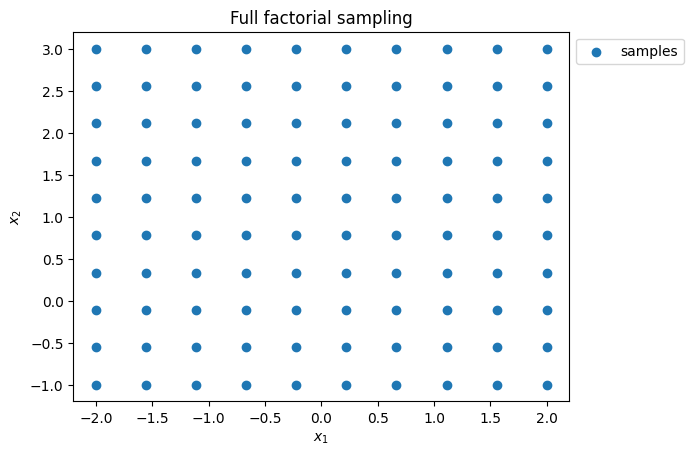

In [3]:
bounds = np.array([lb,ub])

n_levels = np.array([int(np.sqrt(n_samples)),int(np.sqrt(n_samples))])
full_fact = gridsamp(bounds,n_levels)

# Assuming `full_fact` is your data
plt.scatter(full_fact[:, 0], full_fact[:, 1], label='samples')
plt.title('Full factorial sampling')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(bbox_to_anchor=(1.0, 1.0),loc='upper left')
plt.show()

Latin hypercube sampling relies on random dispersion to span the design space and generally provides good coverage for highdimensional spaces

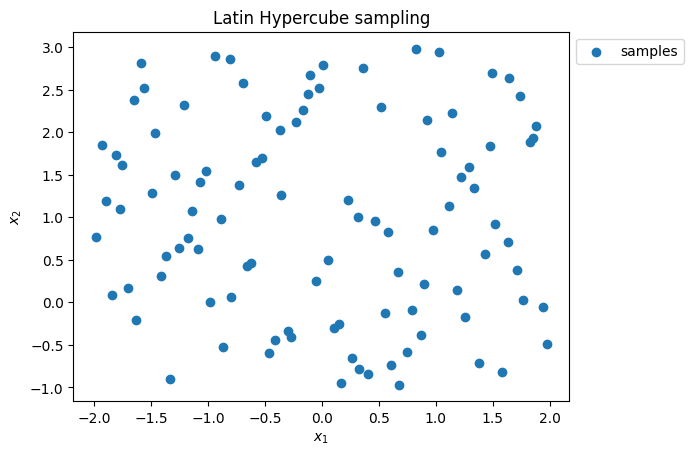

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc


# Create a Latin Hypercube sampling grid
lhc = qmc.LatinHypercube(d=2)
samples = lhc.random(n_samples)

# Scale the samples to the given bounds
lhs = lb + (ub - lb) * samples

# Plot the samples
plt.scatter(lhs[:, 0], lhs[:, 1], label='samples')
plt.title('Latin Hypercube sampling')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(bbox_to_anchor=(1.0, 1.0),loc='upper left')
plt.show()


# Surrogate modeling

Surrogate models are used in lieu of expensive engineering models to help in model-based design optimization. They are constructed from observations of the actual engineering model $y(\mathbf{x})$ and yield a surrogate $\hat{y}(\mathbf{x})$ that is less expensive to evaluate

## test function: Rosenbrock
Let us consider an example where $y(\mathbf{x})$ is given by the Rosenbrock function

$$
y(\mathbf{x}) = {\left(1 - x_1\right)}^2 + 100{\left(x_2 - x_1^2\right)}^2
$$

We plot it below

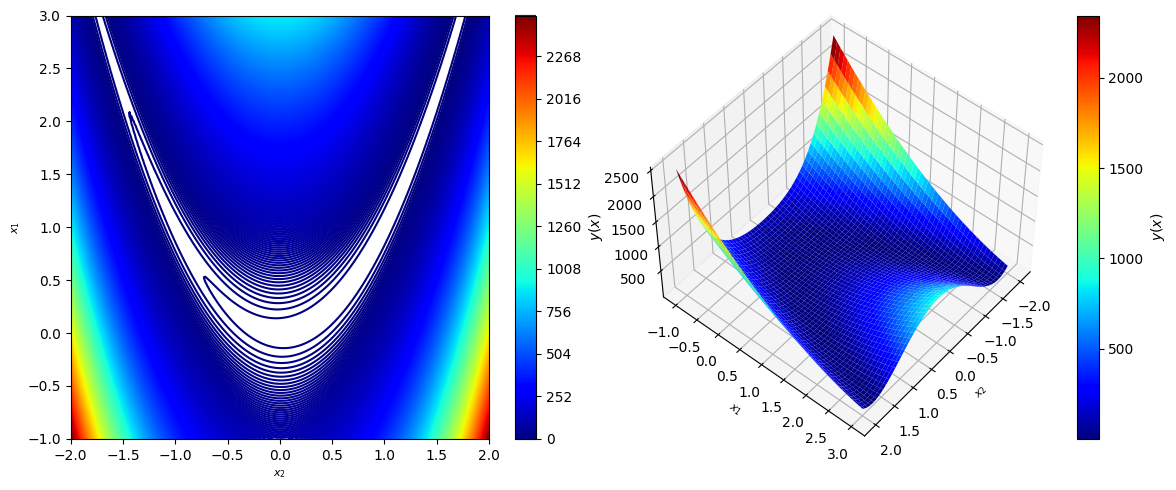

In [5]:
rosen = lambda x1,x2 : (1.0 - x1)**2 + 100.0 * (x2 - x1**2)**2

# Grid for plotting
bounds_plot = np.vstack([lb, ub])

n_grids = 200
x_plot = np.linspace(bounds_plot[0, 0], bounds_plot[1, 0], n_grids)
y_plot = np.linspace(bounds_plot[0, 1], bounds_plot[1, 1], n_grids)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# Compute true function value
Z_plot = rosen(X_plot, Y_plot)

fig = plt.figure(figsize=(12, 5))

# Contour plot
ax1 = fig.add_subplot(1, 2, 1)
contour = ax1.contour(X_plot, Y_plot, Z_plot, levels=1000, cmap='jet')
fig.colorbar(contour, ax=ax1, label="$y(x)$")
ax1.set_xlabel('$x_2$', fontsize=8)
ax1.set_ylabel('$x_1$', fontsize=8)

# Surface plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax2.plot_surface(X_plot, Y_plot, Z_plot, cmap='jet')
fig.colorbar(surf, ax=ax2, label="$y(x)$")
ax2.set_xlabel('$x_2$', fontsize=8)
ax2.set_ylabel('$x_1$', fontsize=8)
ax2.view_init(50, 40)

# Save the figure
plt.tight_layout()
# plt.savefig('rosenbrock.pdf')

## Sampling (training data)

We sample the Rosenbrock function at the Latin hypercube points below

In [6]:
Y = rosen(lhs[:,0],lhs[:,1]) # evaluate LHS samples using Rosenbrock

## Polynomial regression

Polynomial regression assumes that the underlying model $y(x)$ is given by a polynomial function in terms of observations of data $\mathbf{x},\mathbf{y}$. At a given location $\boldsymbol{\zeta}$:

* The model is given by     
$$
\displaystyle \hat{y}(\boldsymbol {\zeta} ) = \mathbf{z}(\boldsymbol {\zeta})^{\mathrm{T}}\mathbf{w},
$$
where $\boldsymbol{\zeta} \in \mathbb{R}^n$ is $n$ dimensional point we want to make predictions at, \
$\mathbf{z}:\mathbb{R}^n \rightarrow \mathbb{R}^{nd+1}$ is the polynomial function of degree $d$,\
and $\mathbf{w} \in \mathbb{R}^{nd+1}$ are its corresponding weights (what we are trying to optimize).\
For example, a polynomial function of degree $d$ looks like\

$$
\mathbf{z}(\mathbf{x}) = \begin{bmatrix} 1 & x_1 & \cdots & x_n & x_1^2 & \cdots & x_n^2 & x_1^d & \cdots & x_n^d \end{bmatrix}^\mathrm{T}
$$

* Consider $p$ training points $\mathbf{x}_1 \cdots \mathbf{x}_p$ and their corresponding function values $\mathbf{y} = \left[y_1,y_2,\cdots,y_p\right]$.
we can write a matrix $\mathbf{Z} \in \mathbb{R}^{p\times{nd+1}}$ as follows
$$
\mathbf{Z}=
\begin{bmatrix}
    1       & x_{11}    & \cdots    & x_{n1}    & x_{11}^2  & \cdots    & x_{n1}^2  & x_{11}^d  & \cdots    & x_{n1}^d  \\
    1       & x_{12}    & \cdots    & x_{n2}    & x_{12}^2  & \cdots    & x_{n2}^2  & x_{12}^d  & \cdots    & x_{n2}^d  \\
    \vdots  & \vdots    & \ddots    & \vdots    & \vdots    & \ddots    & \vdots    & \vdots    & \ddots    & \vdots    \\
    1       & x_{1p}    & \cdots    & x_{np}    & x_{1p}^2  & \cdots    & x_{np}^2  & x_{1p}^d  & \cdots    & x_{np}^d  \\
\end{bmatrix} =
\left[\mathbf{z}(\mathbf{x}_1)~\mathbf{z}(\mathbf{x}_2)~\cdots~\mathbf{z}(\mathbf{x}_p)\right]^{\mathrm{T}}
$$

* We want to find the optimal weights such that
\begin{align*}
    & \underset{\mathbf{w}\in\mathbb{R}^{nd+1}}{\text{minimize}}
    & & ||{\mathbf{Z}\mathbf{w}-\mathbf{y}}||_2^2 + \underbrace{\mathbf{w}^\mathrm{T}{\mathbf{J}}\mathbf{w}}_{\mathrm{regularization~term}}\\		
\end{align*}
The reguralization term is added to avoid an ill-conditioned design matrix ${\mathbf{Z}}^{\mathrm{T}}{\mathbf{Z}}$ when finding the solution by matrix inversion using first-order necessary conditions (FONCs).

${\mathbf{J}}=\mathrm{diag}\left(\left[0~r~\cdots~r\right]^{\mathrm{T}}\right)$, $r$ is the ridge parameter

$$
\left(\mathbf{Z}^{\mathrm{T}}\mathbf{Z} + \mathbf{J}\right)\mathbf{w}^* = \mathbf{Z}^{\mathrm{T}}\mathbf{y}
$$

see the file [surrogate.py](./surrogate.py) for an example implementation of RBFs. We train a 2nd degree polynomial regression model below using samples from the Rosenbrock function


In [7]:
# train the model
ls_surrogate = Surrogate(X=lhs, Y=Y[:,None], type="LS", lb=lb, ub=ub, r=0.0, d=2)
ls_surrogate.train()

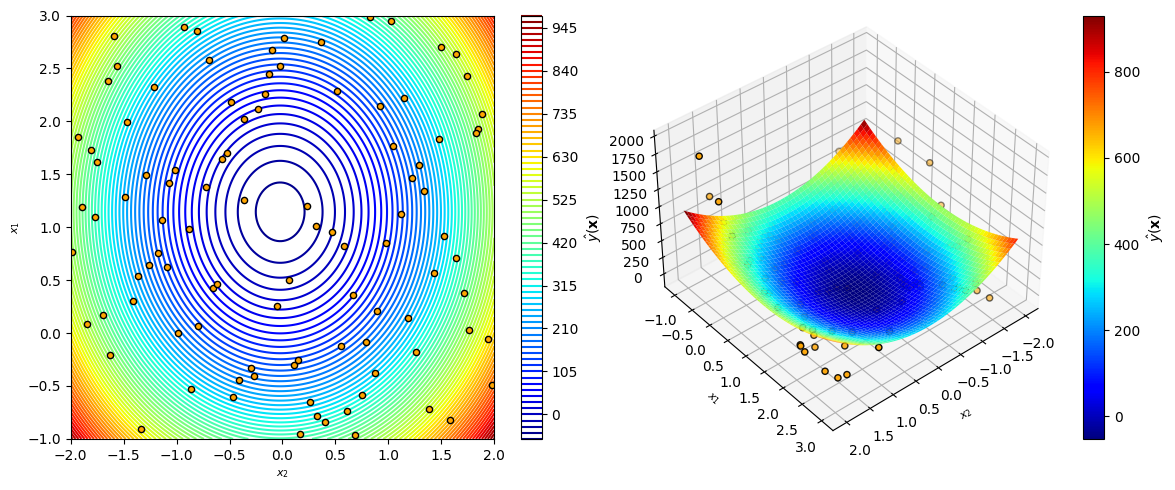

In [8]:
x_predict = np.hstack((X_plot.reshape(-1,1),Y_plot.reshape(-1,1)))

# Predictions
zh = ls_surrogate.predict(x_predict)
Zh = zh.reshape(X_plot.shape)
fig = plt.figure(figsize=(12, 5))

# Contour plot
ax1 = fig.add_subplot(1, 2, 1)
contour = ax1.contour(X_plot, Y_plot, Zh, levels=100, cmap='jet')
ax1.scatter(lhs[:,0],lhs[:,1],c="orange",s=20,edgecolors="k",zorder=2,label="LHS samples")
fig.colorbar(contour, ax=ax1, label="$\hat{y}(\mathbf{x})$")
ax1.set_xlabel('$x_2$', fontsize=8)
ax1.set_ylabel('$x_1$', fontsize=8)

# Surface plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax2.plot_surface(X_plot, Y_plot, Zh, cmap='jet')
ax2.scatter(lhs[:,0],lhs[:,1],Y,c="orange",s=20,edgecolors="k")
fig.colorbar(surf, ax=ax2, label="$\hat{y}(\mathbf{x})$")
ax2.set_xlabel('$x_2$', fontsize=8)
ax2.set_ylabel('$x_1$', fontsize=8)
ax2.view_init(40, 50)

# Save the figure
plt.tight_layout()
# plt.savefig('rosenbrock.pdf')

### A note on the regularization

sometimes an ill-conditioned design matrix $\mathbf{Z}^{\mathrm{T}}\mathbf{Z}$ may result due to the way the data is sampled. We have two data sets shown below. The top row of plots shows a linear regression model through data set 1 [sample_data_1.csv](./sample_data_1.csv). The second row shows a linear regression model trained from data set 2 [sample_data_2.csv](./sample_data_2.csv). Data set 2 has a measurement error in of the data points.

We investigate the effect of the ridge parameter $r$ on the model fit. We increase the ridge parameter from $r=0$ (no regularization) to $r=0.1$. We see that the two models become equivalent after applying some regularization.

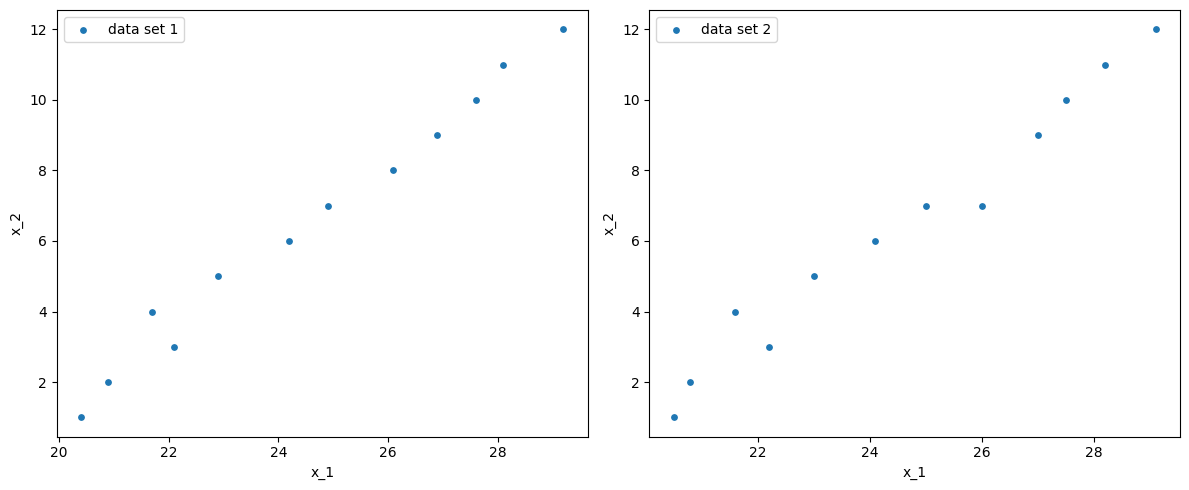

In [9]:
import pandas as pd

# read the data sets
data = pd.read_csv("sample_data_1.csv")
X_data_1 = data.iloc[:,2:4].to_numpy()
Y_data_1 = data.iloc[:,1:2].to_numpy()

data = pd.read_csv("sample_data_2.csv")
X_data_2 = data.iloc[:,2:4].to_numpy()
Y_data_2 = data.iloc[:,1:2].to_numpy()

# create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# scatter plot for data set 1
axs[0].scatter(X_data_1[:,1], X_data_1[:,0], label = "data set 1", s=15)
axs[0].set_xlabel("x_1")
axs[0].set_ylabel("x_2")
axs[0].legend()

# scatter plot for data set 2
axs[1].scatter(X_data_2[:,1], X_data_2[:,0], label = "data set 2", s=15)
axs[1].set_xlabel("x_1")
axs[1].set_ylabel("x_2")
axs[1].legend()

# display the figure with subplots
plt.tight_layout()
plt.show()

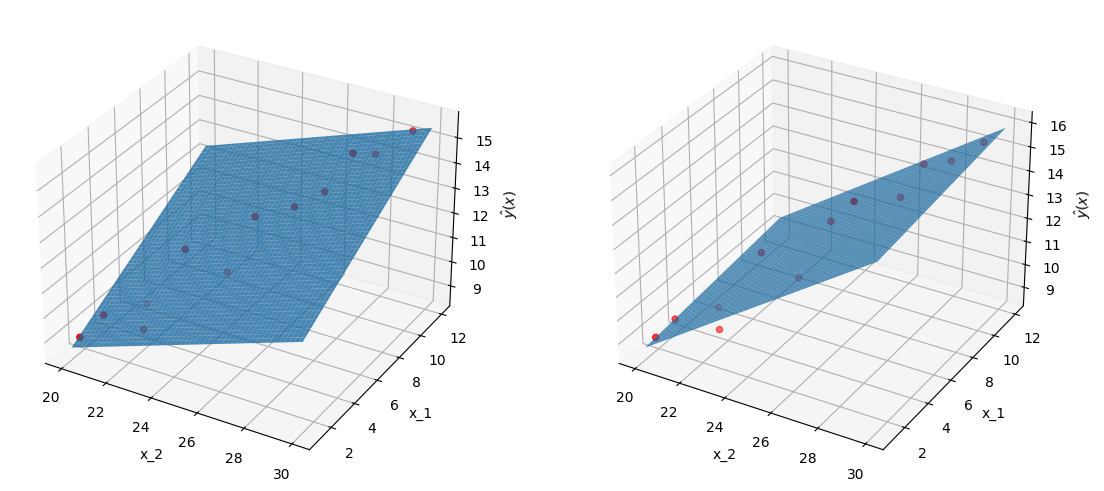

In [10]:
# Parameters
ridge = 0.01
degree = 1
scale = True

# Plot bounds
lb_reg = np.array([1.0, 20.0])
ub_reg = np.array([12.0, 30.0])
bounds_reg = np.vstack([lb_reg, ub_reg])

n_grids = 200
n_reg = np.array([n_grids,n_grids])
X_predict_reg = gridsamp(bounds_reg,n_reg)

X_reg = X_predict_reg[:,0].reshape(n_reg)
Y_reg = X_predict_reg[:,1].reshape(n_reg)

# Assuming X_data_1, Y_data_1, X_data_2, and Y_data_2 are defined
ls1 = Surrogate(X=X_data_1, Y=Y_data_1, 
                type="LS", lb=lb_reg, ub=ub_reg, r=ridge, d=degree, scale=scale)
ls1.train()

ls2 = Surrogate(X=X_data_2, Y=Y_data_2, 
                type="LS", lb=lb_reg, ub=ub_reg, r=ridge, d=degree, scale=scale)
ls2.train()

# Predictions
y_hat_1 = ls1.predict(X_predict_reg)
y_hat_2 = ls2.predict(X_predict_reg)

# Surface plot
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(Y_reg, X_reg, y_hat_1.reshape(Y_reg.shape), alpha=0.8)
ax1.scatter(X_data_1[:, 1], X_data_1[:, 0], Y_data_1, c='r', label="samples")
ax1.set_xlabel("x_2")
ax1.set_ylabel("x_1")
ax1.set_zlabel("$\hat{y}(x)$")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(Y_reg, X_reg, y_hat_2.reshape(Y_reg.shape), alpha=0.8)
ax2.scatter(X_data_2[:, 1], X_data_2[:, 0], Y_data_2, c='r', label="samples")
ax2.set_xlabel("x_2")
ax2.set_ylabel("x_1")
ax2.set_zlabel("$\hat{y}(x)$")

plt.tight_layout()
plt.show()

The condition number of the matrix $A$ is given by $\kappa(A) = \dfrac{\left|\lambda_\mathrm{max}(A)\right|}{\left|\lambda_\mathrm{min}(A)\right|}$, where $\lambda_\mathrm{max}(A)$ and $\lambda_\mathrm{min}(A)$ are the largest and smallest eigenvalues, respectively. The higher the condition number, the more ill-conditioned is the matrix $A$, i.e. the existence of an inverse. Below we check the condition numbers of the design matrix for both regression models.

In [11]:
import numpy as np

c1 = np.linalg.cond(ls1.model.B.T @ ls1.model.B + ls1.model.J)
c2 = np.linalg.cond(ls2.model.B.T @ ls2.model.B + ls1.model.J)

print("Condition number for model trained from data set 1:", c1)
print("Condition number for model trained from data set 2:", c2)

Condition number for model trained from data set 1: 1043.2798609065906
Condition number for model trained from data set 2: 763.4936501862258


## Radial basis function networks

Radial basic function (RBF) neural networks assume the the underlying model $y(x)$ is a result of combined effect of all the training points $\mathbf{x},\mathbf{y}$ at a location $\boldsymbol{\zeta}$. The effect of each training point decays as the distance from said point grows. Distance is given by the $l2$-norm $||\mathbf{x} - \boldsymbol{\zeta}||_2$

* The model is given by 
$$
\displaystyle \hat{y}(\boldsymbol {\zeta} ) = \sum _{i=1}^{p}w_{i}\,b_{i} (\boldsymbol {\zeta}) = \mathbf{b}(\boldsymbol {\zeta})^{\mathrm{T}}\mathbf{w},
$$
where $\boldsymbol{\zeta} \in \mathbb{R}^n$ is the point we want to make predictions at, and $p$ is the number of training points

* $b_{i} : \mathbb{R}^n \rightarrow \mathbb{R}$ is the kernel function and $w_i$ is its corresponding weight (what we are trying to optimize)
$$
b_{i} (\boldsymbol {\zeta}) = \phi (\lambda ||{\boldsymbol {\zeta} -\mathbf {x} _{i}}||_2^2)
$$
typically the Guassian kernel function $\phi(x) = e^{-x}$

* Consider $p$ training points $\mathbf{x}_1 \cdots \mathbf{x}_p$ and their corresponding function values $\mathbf{y} = \left[y_1,y_2,\cdots,y_p\right]$.
we can write a matrix $\mathbf{B} \in \mathbb{R}^{p\times p}$ in terms of the kernel functions $\mathbf{b} : \mathbb{R}^n \rightarrow \mathbb{R}^p$ as follows
$$
\mathbf{B}=\left[\mathbf{b}(\mathbf{x}_1)~\mathbf{b}(\mathbf{x}_2)~\cdots~\mathbf{b}(\mathbf{x}_p)\right]^{\mathrm{T}}
$$

* We want to find the optimal weights such that
\begin{align*}
    & \underset{\mathbf{w}\in\mathbb{R}^p}{\text{minimize}}
    & & ||{\mathbf{B}\boldsymbol{w}-\mathbf{y}}||_2 + \underbrace{\mathbf{w}^\mathrm{T}{\mathbf{J}}\mathbf{w}}_{\mathrm{regularization~term}}\\		
\end{align*}

using FONCs

$$
\left(\mathbf{B}^{\mathrm{T}}\mathbf{B} + \mathbf{J}\right)\mathbf{w}^* = \mathbf{B}^{\mathrm{T}}\mathbf{y}
$$

see the file [surrogate.py](./surrogate.py) for an example implementation of RBFs. We train a radial basis function network model using observations from the Rosenbrock function below


In [12]:
# train the model
rbf_surrogate = Surrogate(X=lhs, Y=Y[:,None], type="RBF", lb=lb, ub=ub, r=0.0, λ=0.05)
rbf_surrogate.train()

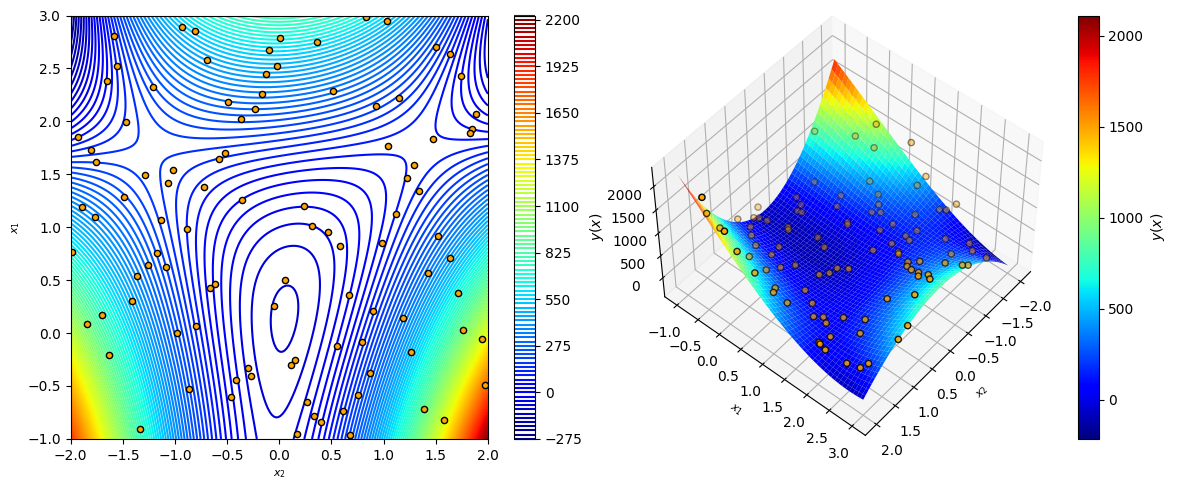

In [13]:
# Predictions
zh = rbf_surrogate.predict(x_predict)
Zh = zh.reshape(X_plot.shape)
fig = plt.figure(figsize=(12, 5))

# Contour plot
ax1 = fig.add_subplot(1, 2, 1)
contour = ax1.contour(X_plot, Y_plot, Zh, levels=100, cmap='jet')
ax1.scatter(lhs[:,0],lhs[:,1],c="orange",s=20,edgecolors="k",zorder=2,label="LHS samples")
fig.colorbar(contour, ax=ax1, label="$y(x)$")
ax1.set_xlabel('$x_2$', fontsize=8)
ax1.set_ylabel('$x_1$', fontsize=8)

# Surface plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax2.plot_surface(X_plot, Y_plot, Zh, cmap='jet')
ax2.scatter(lhs[:,0],lhs[:,1],Y+100,c="orange",s=20,edgecolors="k")
fig.colorbar(surf, ax=ax2, label="$y(x)$")
ax2.set_xlabel('$x_2$', fontsize=8)
ax2.set_ylabel('$x_1$', fontsize=8)
ax2.view_init(50, 40)

# Save the figure
plt.tight_layout()
# plt.savefig('rosenbrock.pdf')

### A note on the spread parameter $\lambda$

$\lambda$ must be carefully chosen so that the effect of each training point overlaps with that of nearby points. Otherwise, this results in a poor fit due to the independence of the training points

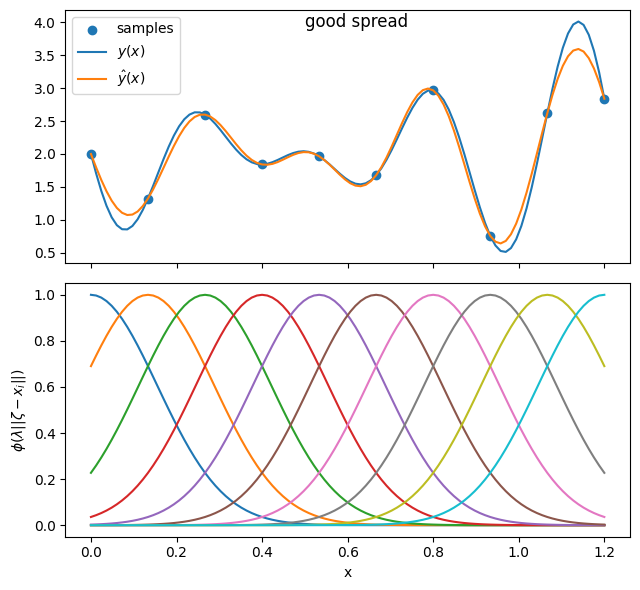

In [14]:
from surrogate import scaling

def test_fun_1D(x):
    return -(1.4 - 3.0 * x) * np.sin(18.0 * x) + 2

# Plot bounds data
lb_spread = np.array([0.0])
ub_spread = np.array([1.2])
n_samples = 10

bounds_1d = np.array([lb_spread, ub_spread])
ns = [n_samples]
X_1d = np.linspace(bounds_1d[0, 0], bounds_1d[1, 0], ns[0])

# Training data
Y_1d = test_fun_1D(X_1d)

# train the model
rbf1 = Surrogate(X=X_1d[:,None], Y=Y_1d[:,None], type="RBF", lb=lb_spread, ub=ub_spread, r=0.0, λ=30.0, name="1D RBF good")
rbf1.train()

x_plot_1d = np.linspace(0, 1.2, 100)
x_plot_1d_scaled = scaling(x_plot_1d,lb_spread,ub_spread,1)

y_plot_1d = rbf1.predict(x_plot_1d.reshape(-1, 1))
B = rbf1.model.basis(rbf1.model.λ,x_plot_1d_scaled)

# Plot basis functions and test function
fig, axs = plt.subplots(2, 1, figsize=(6.5, 6), sharex=True)

# Assuming the previous plots
axs[0].scatter(X_1d, Y_1d, label="samples")
axs[0].plot(x_plot_1d, test_fun_1D(x_plot_1d), label="$y(x)$")
axs[0].plot(x_plot_1d, y_plot_1d, label="$\hat{y}(x)$")
axs[0].text(0.5, 4.0, 'good spread', fontsize=12, va='center', ha='left')
axs[0].legend(loc="upper left")

# Assuming B is already defined
for i in range(B.shape[0]):
    axs[1].plot(x_plot_1d, B[i, :], label="_nolegend_")  # no legend for these lines
axs[1].set_xlabel("x")
axs[1].set_ylabel("$\phi (\lambda ||{\zeta -x_{i}}||)$")

plt.tight_layout()
plt.show()
# To save the figure, uncomment the next line
# plt.savefig("rbf_good.pdf")


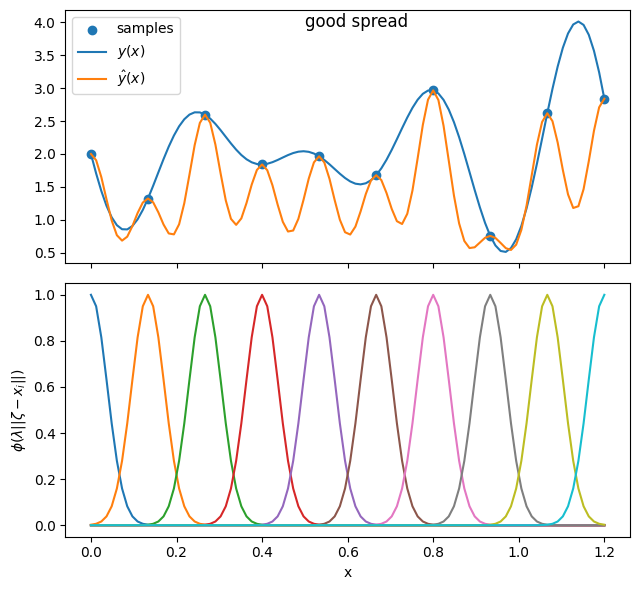

In [15]:
# train the model
rbf1 = Surrogate(X=X_1d[:,None], Y=Y_1d[:,None], type="RBF", lb=lb_spread, ub=ub_spread, r=0.0, λ=500.0, name="1D RBF good")
rbf1.train()

y_plot_1d = rbf1.predict(x_plot_1d.reshape(-1, 1))
B = rbf1.model.basis(rbf1.model.λ,x_plot_1d_scaled)

# Plot basis functions and test function
fig, axs = plt.subplots(2, 1, figsize=(6.5, 6), sharex=True)

# Assuming the previous plots
axs[0].scatter(X_1d, Y_1d, label="samples")
axs[0].plot(x_plot_1d, test_fun_1D(x_plot_1d), label="$y(x)$")
axs[0].plot(x_plot_1d, y_plot_1d, label="$\hat{y}(x)$")
axs[0].text(0.5, 4.0, 'good spread', fontsize=12, va='center', ha='left')
axs[0].legend(loc="upper left")

# Assuming B is already defined
for i in range(B.shape[0]):
    axs[1].plot(x_plot_1d, B[i, :], label="_nolegend_")  # no legend for these lines
axs[1].set_xlabel("x")
axs[1].set_ylabel("$\phi (\lambda ||{\zeta -x_{i}}||)$")

plt.tight_layout()
plt.show()
# To save the figure, uncomment the next line
# plt.savefig("rbf_good.pdf")

## Kriging surrogate models

We use a popular surrogate modeling known as Kriging (named after the South African geoscientist Krige). Kriging is a geostatistical technique to interpolate the elevation of the landscape as a function of the geographic location at an unobserved location from observations of its value at nearby locations.

* Basic idea assume that the true function is 
$$\hat{y}(x) = f(x) + Z(x)$$
* Where $Z(x)$ is a zero-mean stochastic process that represents the deviation from $f$ ; its covariance is
$$\text{cov}( Z ( x_1 ), Z ( x_2 )) = \sigma^2R( x_1 , x_2 )$$
* R is the spatial correlation function, typically
$$ R( x_1 , x_2 ) = e^{−\theta\left(x_1 − x_2\right)^2} $$
just like the Guassian kernel fucntion in RBF networks
* Use polynomial for $f$ and compute its coefficients using data collected from observations or experiments and correlation function
* we then want to find the polynomial coefficients that minimize the covariance subject to the condition that mean is zero

see [https://www.omicron.dk/dace/dace.pdf](https://www.omicron.dk/dace/dace.pdf) for details of the derivation

In this example, We use [`smt.surrogate_models.KRG`](https://smt.readthedocs.io/en/latest/_src_docs/surrogate_models/krg.html) from the [SMT](https://smt.readthedocs.io/en/latest/index.html) library


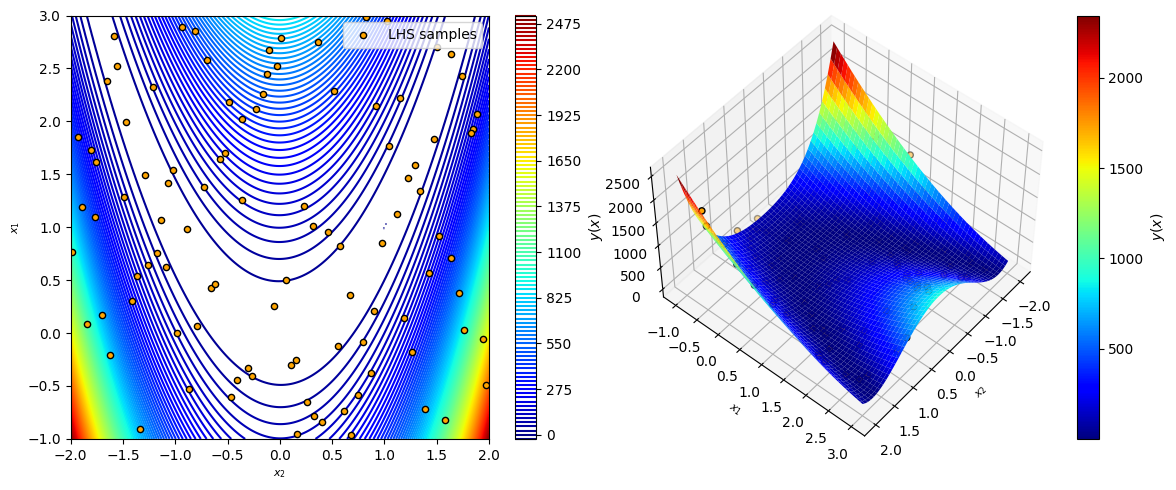

In [16]:
from smt.surrogate_models import KRG

# train the model
sm = KRG(theta0=[0.03,],corr="squar_exp",poly="constant", print_global=False)
sm.set_training_values(lhs, Y)
sm.train()

X1,X2 = np.meshgrid(np.linspace(0,100,40),np.linspace(0,100,40))
X = np.hstack((X1.reshape([-1,1]),X2.reshape([-1,1]))) # flatten grids side-by-side

# Predictions
zh = sm.predict_values(x_predict)
Zh = zh.reshape(X_plot.shape)
fig = plt.figure(figsize=(12, 5))

# Contour plot
ax1 = fig.add_subplot(1, 2, 1)
contour = ax1.contour(X_plot, Y_plot, Zh, levels=100, cmap='jet')
ax1.scatter(lhs[:,0],lhs[:,1],c="orange",s=20,edgecolors="k",zorder=2,label="LHS samples")
fig.colorbar(contour, ax=ax1, label="$y(x)$")
ax1.set_xlabel('$x_2$', fontsize=8)
ax1.set_ylabel('$x_1$', fontsize=8)
ax1.legend()

# Surface plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax2.plot_surface(X_plot, Y_plot, Zh, cmap='jet')
ax2.scatter(lhs[:,0],lhs[:,1],Y+100,c="orange",s=20,edgecolors="k")
fig.colorbar(surf, ax=ax2, label="$y(x)$")
ax2.set_xlabel('$x_2$', fontsize=8)
ax2.set_ylabel('$x_1$', fontsize=8)
ax2.view_init(50, 40)

# Save the figure
plt.tight_layout()
# plt.savefig('kriging_example.pdf')

## Cross-validation

There are several metrics to assess the performance of the surrogate model $\hat{y}(\mathbf{x}$

* The “R-square” (coefficient of determination)
$$
R^2 = 1 - \frac{\sum_i\left(y_i-\bar{y}\right)^2}{\sum_i\left(\hat{y}_i-{y}_i\right)^2}
$$
* Mean square error (MSE)
$$
\text{MSE} = \dfrac{1}{n}\sum_{i=1}^{n}\left(\hat{y}_i-{y}_i\right)^2
$$
* Root mean square error (RMSE)
$$
\text{RMSE} = \sqrt{\dfrac{1}{n}\sum_{i=1}^{n}\left(\hat{y}_i-{y}_i\right)^2}
$$

These errors can be computed using various cross-validation strategies:
* Leave-one-out
    * Use $N-1$ points to create metamodel
    * Compute error on left-out point
    * Repeat $N$ times
    * Maximum error found bounds error of metamodel created using N points (under certain conditions)
* k-fold cross-validation
    * Partition the data into $k$ *segments* (folds)
    * Use $k-1$ segments to create metamodel
    * Compute error on the $k$th segment
    * Repeat $k$ times
    * Maximum error found bounds error of metamodel created using $k$-folds (under certain conditions)
    * Average MSE error found using
$$
\text{MSE}_{k\text{-fold}} = \dfrac{1}{k}\sum_{i=1}^{k}\text{MSE}_k
$$

Lets us examine the $k$-fold cross-validation error as we change the parameters of the Kriging model:

Effect of $\theta$:

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def KfoldCV(X, Y, theta, n_folds=5):
    kf = KFold(n_splits=n_folds)
    MSE = 0
    for train_index, test_index in kf.split(X):
        # train the model
        sm = KRG(theta0=[theta,],corr="squar_exp",poly="quadratic", print_global=False)
        sm.set_training_values(X[train_index], Y[train_index])
        sm.train()
        sm.optimal_theta = np.array([theta,1e-3]) # disable hyperparameter tuning

        # Predictions
        Y_predict = sm.predict_values(X[test_index])

        # error
        MSE += mean_squared_error(Y_predict, Y[test_index])
    MSE /= n_folds
    return MSE

thetas = np.linspace(1e-3, 1e0, 10)
error_theta = [KfoldCV(lhs,Y,n_folds=5,theta=theta) for theta in thetas]


Effect of number of training points $p$ on the Kriging model:

In [18]:
from numpy import linalg as LA

def error_sampling(X, Y, n_samples):
    total_samples = len(X)
    n = min(total_samples-20, n_samples) # cap n at 160

    # train the model
    sm = KRG(theta0=[0.03,],corr="squar_exp",poly="quadratic", print_global=False)
    sm.set_training_values(X[:n], Y[:n])
    sm.train()

    # Predictions
    Y_predict = sm.predict_values(X[total_samples-20:total_samples])

    # error
    MSE = mean_squared_error(Y_predict, Y[total_samples-20:total_samples])
    return MSE

ns = range(20, 81, 2)
error_n = [error_sampling(lhs,Y,n_samples=n) for n in ns]


Plotting $\text{MSE}_{k\text{-fold}}$ versuse $\theta$ and $p$

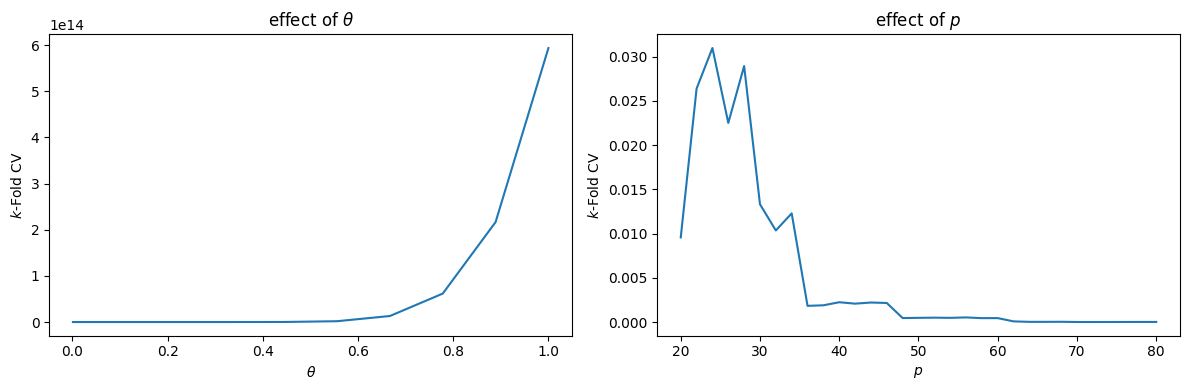

In [19]:
import matplotlib.pyplot as plt

# theta plot
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(thetas, error_theta, linestyle='-')
plt.title(r"effect of $\theta$")
plt.xlabel(r"$\theta$")
plt.ylabel("$k$-Fold CV")

# samples plot
plt.subplot(122)
plt.plot(ns, error_n, linestyle='-')
plt.title("effect of $p$")
plt.xlabel("$p$")
plt.ylabel("$k$-Fold CV")

plt.tight_layout()
plt.show()